# Titanic competition via decision trees

In this notebook, we will predict passenger survival using decision trees.

We start off by loading some of the necessary libraries and the cleaned data generated in `titanic_data_cleaning.ipynb`.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import graphviz # for visualising decision trees

from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [2]:
titanic = pd.read_csv( 'train_cleaned.csv' )
test = pd.read_csv( 'test_cleaned.csv' )

# Remove the 'PassengerId' from the data and keep the 'Survived' column as target vector Y.
submission=test[['PassengerId']]
test=test.drop('PassengerId', axis=1)

X=titanic.drop('Survived', axis=1)
X=X.drop('PassengerId', axis=1)
Y=titanic[['Survived']]
data=X.to_numpy()
target=Y.to_numpy().reshape(-1,)

y_true=Y.values.T[0] # ground truth vector

Define the tree claffisier.

In [3]:
clf = tree.DecisionTreeClassifier()

## Regularisation

We look for the optimal pruning parameter `ccp_alpha` via Grid Search Cross-validation. 

In [4]:
alpha_grid = np.logspace(-4, 0, 64)

param_grid = {
    "ccp_alpha": alpha_grid,
}

In [5]:
search = GridSearchCV(
    clf, param_grid, n_jobs=-1, return_train_score=True, cv=StratifiedKFold(
        n_splits=5, shuffle=True, random_state=345
    )
)

search.fit(data, target)

print(
    "Best parameter (CV score=%0.3f):" % search.best_score_
)

print(search.best_params_)

Best parameter (CV score=0.830):
{'ccp_alpha': 0.008030857221391512}


Plot the Grid Search results.

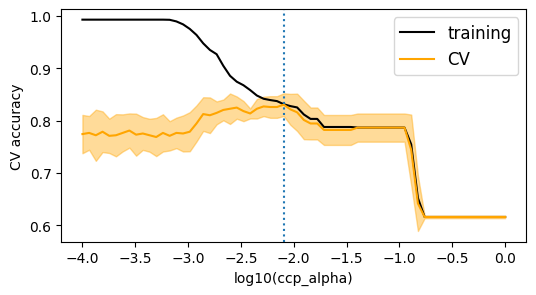

In [6]:
fig, ax1 = plt.subplots(nrows=1, figsize=(6, 6))
results = pd.DataFrame(search.cv_results_)
results["log_param_ccp_alpha"] = np.log10(results.param_ccp_alpha.values.astype(float))
alpha_col = "log_param_ccp_alpha"

results.plot(
    x=alpha_col, y="mean_train_score", legend=False, ax=ax1, c='black', label="training"
)

ax1.fill_between(
    results["log_param_ccp_alpha"], 
    results["mean_test_score"]-results["std_test_score"], 
    results["mean_test_score"]+results["std_test_score"],
    color='orange', alpha=0.4
)

results.plot(
    x=alpha_col, y="mean_test_score", legend=False, ax=ax1, c='orange', label="CV"
)

ax1.axvline(
    np.log10(search.best_params_['ccp_alpha']),
    linestyle=":"
)

ax1.legend(prop=dict(size=12))

ax1.set_ylabel("CV accuracy")
ax1.set_xlabel("log10(ccp_alpha)")
ax1.set_box_aspect(.5)

The grid search shows that the optimal value of the pruning parameter is $\alpha\approx 0.008$.

## Predictions

We set the pruning parameter to the optimal one and fit the classifier.

In [7]:
opt_params={'ccp_alpha': search.best_params_['ccp_alpha']}
clf.set_params(**opt_params)

clf.fit(data, target)
y_pred=clf.predict(data)
print("Training accuracy:\t"+str(accuracy_score(y_true, y_pred)))

scores = cross_val_score(
    clf, data, target, cv=StratifiedKFold(
        n_splits=5, shuffle=True
    ), scoring='accuracy'
)
print( "CV accuracy:\t"+str(scores.mean()) )
print( "CV std:\t"+str(scores.std()) )

Training accuracy:	0.8271604938271605
CV accuracy:	0.8193019898311468
CV std:	0.012022229237774405


Let's plot the resulting decision tree.

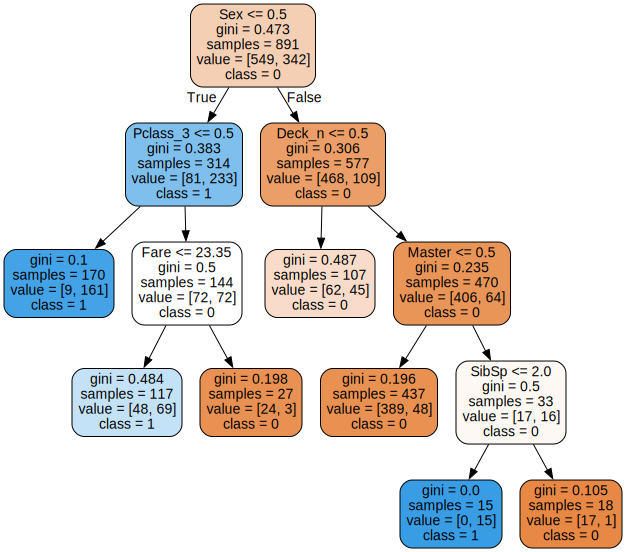

In [8]:
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.keys(), class_names=['0','1'], rounded=True, filled=True)
graph = graphviz.Source(dot_data) 
graph

Finally, we create the submission file.

In [9]:
submission["Survived"]=clf.predict(test)
print(submission.head())
submission.to_csv('submission_tree.csv',index=False)

   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
